In [19]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm

## Подключение к данным

In [3]:
driver = 'postgresql'
port = '19277'
user = 'reader'
password = 'TzR1e|eTXcdRb*i'
host = '3.64.150.15'
db = 'db_production'

cs = create_engine(f'{driver}://{user}:{password}@{host}:{port}/{db}')

# Вопрос 1. Отдел трафика
Мы хотим настроить таргетинг рекламы по полу и возрасту пользователей, чтобы закупать трафик максимально эффективно и прибыльно. На какой сегмент пользователей нам лучше всего настроить таргетинг?

## Импорт данных

In [3]:
users_query = '''
        select id,
               sex,
               date_part('year', age(current_date, date_bd)) as age
        from users as u
        where sex is not null
               and is_test = false
               and date_bd is not null;
        '''
        
users_df = pd.io.sql.read_sql(users_query, con=cs)

In [4]:
transactions_query = '''
                    select id,
                           user_id,
                           status,
                           date(created_at) as date,
                           amount
                    from transactions
                     '''
                     
transactions_df = pd.io.sql.read_sql(transactions_query, con=cs)

In [5]:
successful_transactions = transactions_df.query("status == 'success'")\
    .reset_index(drop=True)

## Обработка данных

<AxesSubplot:xlabel='age', ylabel='Count'>

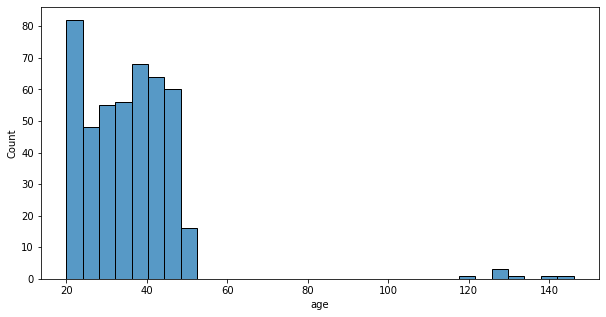

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(x=users_df['age'])

Присутствуют явные аномалии - возраст более 100 лет. Избавимся от выбросов. В качестве границ примем 1.5 межквартильного размаха

In [7]:
IQR = users_df['age'].quantile(0.25) + users_df['age'].quantile(0.75)

print(1.5 * IQR)

102.0


Распределение по возрасту без учёта явных аномалий

<AxesSubplot:xlabel='age', ylabel='Count'>

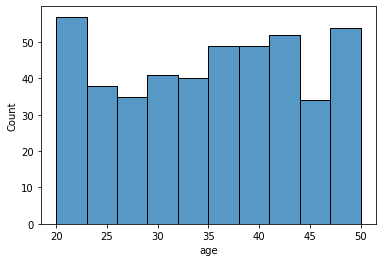

In [8]:
sns.histplot(x=users_df.query('age <= 1.5 * @IQR')['age'])

Распределение по полу юзеров

<AxesSubplot:xlabel='sex', ylabel='count'>

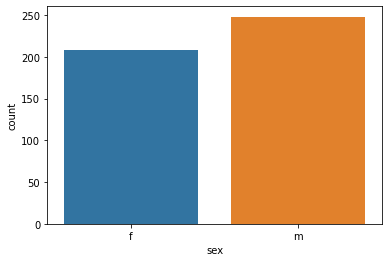

In [9]:
sns.countplot(x=users_df['sex'])

Выясним, кто совершает покупки больше всего

Ранее из данных были удалены юзеры, указавшие заведомо аномальный возраст. Выясним, на какую сумму они произвели транзакции.

In [10]:
users_df.query('age >= 1.5 * @IQR')\
    .merge(successful_transactions,
           left_on='id',
           right_on='user_id')\
    .groupby('user_id', as_index=False)\
    .agg(amount_sum=('amount', 'sum'))

,user_id,amount_sum
0,100172,936.0
1,100263,50.0
2,100579,25.0
3,100962,50.0


Следует проверить юзера с id 100172, так как указан аномальный возраст, при этом совершены покупки на крупную сумму.

Выясним, какие сочетания "пол-возраст" даёт наибольшую сумму успешных транзакций.

In [11]:
grouped_transactions_df = successful_transactions.groupby('user_id', as_index=False)\
    .agg(amount_sum=('amount', 'sum'))

In [12]:
users_amount_sum_df = users_df[['id', 'sex', 'age']]\
    .merge(grouped_transactions_df,
           how='left',
           left_on='id',
           right_on='user_id')\
    .drop('user_id', axis=1)\
    .fillna(0)

In [13]:
pivot_amount_sum = users_amount_sum_df.pivot_table(index='age', columns='sex', values='amount_sum', aggfunc=sum, fill_value=0)

In [14]:
# сумма успешных транзакций в разрезе групп

pivot_amount_sum.style\
    .highlight_max(color='green')\
    .format('{:,}')

sex,f,m
age,,
20.0,386,672
21.0,"8,749","1,579"
22.0,50,"7,523"
23.0,160,50
24.0,0,530
25.0,165,"1,413"
26.0,135,185
27.0,50,25
28.0,"1,229","1,238"


In [15]:
# колюичество юзеров в разрезе групп

users_df.groupby(['age', 'sex'], as_index=False)\
    .agg(unique_users=('id', 'count'))\
    .pivot_table(index='age', columns='sex', values='unique_users', fill_value=0)\
    .style\
    .highlight_max(color='green')\
    .format('{:.0f}')

sex,f,m
age,,
20.0,7,14
21.0,9,8
22.0,6,13
23.0,8,4
24.0,6,7
25.0,5,8
26.0,9,11
27.0,2,4
28.0,5,4


In [16]:
# доход в среднем на пользователя из группы

pivot_amount_sum\
    .divide(users_df.groupby(['age', 'sex'], as_index=False)\
                    .agg(unique_users=('id', 'count'))\
                    .pivot_table(index='age', columns='sex', values='unique_users', fill_value=0))\
    .style\
    .highlight_max(color='green')\
    .format('{:.1f}')

sex,f,m
age,,
20.0,55.1,48.0
21.0,972.1,197.4
22.0,8.3,578.7
23.0,20.0,12.5
24.0,0.0,75.7
25.0,33.0,176.6
26.0,15.0,16.8
27.0,25.0,6.2
28.0,245.8,309.5


## Итоги

Если смотреть только на денежные показатели (сумма успешных транзакций), следует обратить внимание на группы:

1. Ж-40+;
2. М-21...22;
3. М-41...42.

Так как они приносят больший доход. Также это довольно многочисленная группы юзеров. Если верить историческим данным, данная группа при привлечении трафика также покажет хорошие результаты (при расчёте показателей принималось, что все юзеры являются органическими, то есть ранее с ними не проводились целенаправленные коммуникации)

# Вопрос 2. Отдел маркетинга

Мы хотим запустить программу лояльности с 5 уровнями. Уровень присваивается в зависимости от суммы потраченных пользователем денег. Какие пороги уровней сделать и почему?

Если рассматривать только суммы потраченных денег, логичным решением кажется RFM-сегментация юзеров (для лУчших результатов желательно также разделить юзеров по частоте и давности последней активности).

Данное разделение позволит эффективно строить коммуникации с каждой из групп, что в дальнейшем позволит, например, перенести юзера из более низкой группы в более высокую.

В качестве порогов примем квантили распределения.

In [17]:
# обозначим границы для групп

users_amount_sum_df = users_amount_sum_df.query('amount_sum > 0')

M1 = users_amount_sum_df['amount_sum'].quantile(0.2)
M2 = users_amount_sum_df['amount_sum'].quantile(0.4)
M3 = users_amount_sum_df['amount_sum'].quantile(0.6)
M4 = users_amount_sum_df['amount_sum'].quantile(0.8)

<AxesSubplot:ylabel='Frequency'>

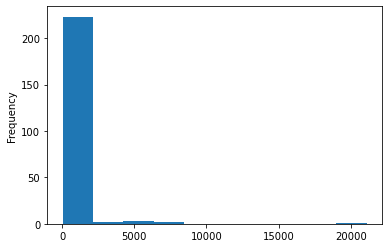

In [18]:
users_amount_sum_df['amount_sum'].plot(kind='hist')

In [19]:
def get_monetary(val):
    
    if val == 0 or val <= M1:
        return 1
    elif M1 < val <= M2:
        return 2
    elif M2 < val <= M3:
        return 3
    elif M3 < val <= M4:
        return 4
    elif val > M4:
        return 5

In [20]:
users_amount_sum_df['monetary'] = users_amount_sum_df['amount_sum'].apply(lambda x: get_monetary(x))

In [21]:
users_amount_sum_df.head()

,id,sex,age,amount_sum,monetary
0,100049,f,35.0,50.0,2
2,100053,m,47.0,25.0,1
9,100066,f,36.0,742.0,5
11,100069,m,36.0,25.0,1
13,100077,f,38.0,50.0,2


<AxesSubplot:>

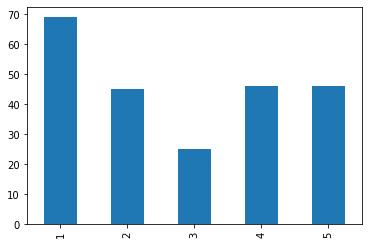

In [22]:
users_amount_sum_df['monetary'].value_counts()\
    .sort_index()\
    .plot(kind='bar')

# Вопрос 3. Отдел трафика

За каждого пользователя, который совершил платеж на проекте, мы платим рекламной сети. Какую сумму мы можем себе позволить платить за каждого привлеченного пользователя, если учесть, что горизонт окупаемости должен быть не больше 1 месяца?

In [23]:
successful_transactions['date'] = pd.to_datetime(successful_transactions['date'])

In [24]:
successful_transactions['y_m'] = successful_transactions['date'].dt.strftime('%Y-%m')

In [25]:
successful_transactions.groupby('y_m', as_index=False)\
    .agg(month_amount=('amount', 'sum'))

,y_m,month_amount
0,2001-10,1777.0
1,2001-11,3336.0
2,2001-12,4172.0
3,2002-01,1084.0
4,2002-02,426.0
5,2002-03,50.0
6,2002-04,828.0
7,2002-05,348.0
8,2002-06,905.0
9,2002-07,350.0


В данных чётко видно разделение на два периода, при этом показатели по суммарным транзакциям за месяц сильно отличаются. При расчёте окупаемости будем принимать второй период: от 2021 года, так как более ранние данные, скорее всего, внесут ошибку

In [26]:
marketing_df = successful_transactions.query("date >= '2022-01-09'")

In [27]:
mean_month_sum = marketing_df.groupby('y_m', as_index=False)\
    .agg(month_amount=('amount', 'sum'))\
    ['month_amount'].mean()
    
print(mean_month_sum)

14288.75


Для расчёта окупаемости трафика возпользуемся метрикой ROIS

$$ROIS = \frac{ценность \ конверсии} {затраты \ на \ рекламу} * 100\%$$

Для точки безубыточности ROIS должен быть равен 1, то есть за каждый вложенный в рекламу рубль компания получает 1 рубль прибыли.

Стоит учитывать, что данная метрика не учитывает издержки при продаже товара/оказании услуги. Издержки в данном задании неизвестны, потому 

для расчёта примем их равными 0.

Если учтём, что ценность конверсии = прибыль за месяц, то для точки безубыточности мы можем тратить не более $14288.75$ у.е.

Для расчёта расходов на клиента воспользуемся метрикой CAC

$$CAC = \frac {расходы \ на \ маркетинг} {количество \ привлечённых \ клиентов}$$

In [28]:
# среднее кол-во привлечённых юзеров за месяц 

acquisition_mean = ceil(marketing_df.groupby('user_id', as_index=False)\
    ['y_m']\
    .min()\
    .groupby('y_m', as_index=False)\
    ['user_id']\
    .nunique()\
    ['user_id'].mean())

In [29]:
CAC = mean_month_sum / acquisition_mean

print(CAC)

386.18243243243245


## Итоги

По имеющимся данным, для точки безубыточности компания не может тратить на привлечение одного юзера более $386.18$ уе

In [5]:
users_q = '''
        select campaign_id,
            uid,
            sum(created_sum) as deps_sum
        from vc_campaign_user_executions      as vcue
                join vc_billing_transactions as vcbt on vcbt.user_id = vcue.uid and
                                                        (process_data -> 'context' ->> 'transactionId')::int = vcbt.id
            and vcbt.status = 'payed'
        where campaign_id in (2382, 2502)
        group by 1, 2
            '''
            
users_df = pd.io.sql.read_sql(users_q, cs)

In [12]:
test_data = users_df.query('campaign_id == 2382')

In [14]:
test_data.head()

,campaign_id,uid,deps_sum
0,2382,8078671,95.0
1,2382,8111636,400.0
2,2382,8132595,100.0
3,2382,8156792,50.0
4,2382,8193072,340.0


In [20]:
def aa_test(group_a, group_b, test_num=10000, users_num=500):
    '''
    Проверка корректности сплитования с помощью многократного проведения t-теста.

    :param test_num: кол-во тестов
    :param users_num: кол-во юзеров в каждом тесте
    :param group_a: группа 1
    :param group_b: группа 2
    :return: ДФ с результатами теста, процент ложноположительного срабатывания
    '''

    # создание ДФ с результатами тестов
    index = 0
    res_df = pd.DataFrame(columns=['t_stat', 'p_value'])

    # цикл проведения тестов
    for _ in tqdm(range(test_num)):

        test_res = {'t_stat': ttest_ind(group_a.sample(users_num, replace=True),
                                        group_b.sample(users_num, replace=True),
                                        equal_var=False)[0],
                    'p_value': ttest_ind(group_a.sample(users_num, replace=True),
                                         group_b.sample(users_num, replace=True),
                                         equal_var=False)[1]}
        res_df = res_df.append(pd.DataFrame(data=test_res,
                                            index=[index]))
        index += 1

    fpr = sum(res_df.p_value <= 0.05) / res_df.shape[0]

    return res_df, fpr